# Housekeeping

In [1]:
import pandas as pd
from pandas.plotting import parallel_coordinates
import seaborn as sns
import numpy as np
import sys
import os
import csv

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d #Axes3D

mpl.rc('axes', labelsize = 14)
mpl.rc('xtick', labelsize = 12)
mpl.rc('ytick', labelsize = 12)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'


!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 12.2 MB/s eta 0:00:00


In [2]:
from rdkit import Chem
from rdkit import ML
from rdkit.Chem import AllChem, Draw, Descriptors, MolFromSmiles, MolToSmiles
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_swiss_roll, load_iris, fetch_openml, make_blobs, load_wine, make_moons, fetch_olivetti_faces
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, silhouette_score, silhouette_samples
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap, MDS, LocallyLinearEmbedding
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading the Dataset

In [7]:
df = pd.read_csv('/content/drive/MyDrive/CHEM70012 Data Analytics in Chemistry/Week 4/Final Project/BindingDB_BindingDB_Articles_202310.tsv',delimiter='\t',usecols=range(50))

<ipython-input-7-f21eee2520e8>:1: DtypeWarning: Columns (10,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/CHEM70012 Data Analytics in Chemistry/Week 4/Final Project/BindingDB_BindingDB_Articles_202310.tsv',delimiter='\t',usecols=range(50))


In [6]:
IC50_ligSMILES = df[['IC50 (nM)','Ligand SMILES']] #making a df consisting only of IC50 and ligand SMILES columns
IC50_ligSMILES['Ligand SMILES'].value_counts() #checking for repeated ligand SMILES values

CC(=O)Nc1nnc(s1)S(N)(=O)=O                                                                           222
ONC(=O)CCCCCCC(=O)Nc1ccccc1                                                                           74
Nc1c2CCCCc2nc2ccccc12                                                                                 73
CS(=O)(=O)c1ccc(cc1)-c1cnc(NCc2ccco2)n2cnnc12                                                         71
CC(C)(C)NC(=O)[C@@H]1CN(Cc2cccnc2)CCN1C[C@@H](O)C[C@@H](Cc1ccccc1)C(=O)N[C@@H]1[C@H](O)Cc2ccccc12     69
                                                                                                    ... 
CCCCN(CC)c1nc(C)nc2N(CC(=O)Nc12)c1ccc(OC)cc1C                                                          1
CCCCN(CC)c1cc(C)nc2N(CCNc12)c1ccc(OC)cc1C                                                              1
CCCCN(CC)c1cc(C)nc2N(CC(=O)Nc12)c1ccc(OC)cc1C                                                          1
CCC(CC)Nc1cc(C)nc(Nc2c(C)cc(C)cc2C)c1C                 

<ipython-input-9-414e190aca2e>:2: DtypeWarning: Columns (10,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('/content/drive/MyDrive/CHEM70012 Data Analytics in Chemistry/Week 4/Final Project/BindingDB_BindingDB_Articles_202310.tsv',delimiter='\t',usecols=range(50))


percentage of ligand-target pairs with IC50 < 1 nM 1.7349769381021944
percentage of ligand-target pairs with IC50 < 2 nM 2.933210774256028
percentage of ligand-target pairs with IC50 < 10 nM 8.456576334061028


<Axes: >

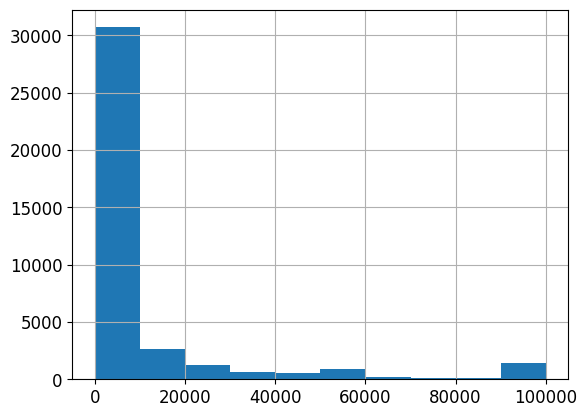

In [9]:
#visualising spread of IC50 values over the whole dataset
df2 = pd.read_csv('/content/drive/MyDrive/CHEM70012 Data Analytics in Chemistry/Week 4/Final Project/BindingDB_BindingDB_Articles_202310.tsv',delimiter='\t',usecols=range(50))
df2 = df.dropna(subset='IC50 (nM)').reset_index(drop=True)
df2['IC50 (nM)'] = df2['IC50 (nM)'].str.strip()

df2['IC50_nM_cleaned'] = df['IC50 (nM)'].str.replace('[><]','',regex=True).astype(float)
df2.loc[df2['IC50 (nM)'].str.contains('>'), 'IC50_nM_cleaned'] = df2[df2['IC50 (nM)'].str.contains('>')]['IC50_nM_cleaned'] - 0.5

print('percentage of ligand-target pairs with IC50 < 1 nM', (df2['IC50_nM_cleaned']<1).sum()/df2.shape[0]*100)
print('percentage of ligand-target pairs with IC50 < 2 nM', (df2['IC50_nM_cleaned']<2).sum()/df2.shape[0]*100)
print('percentage of ligand-target pairs with IC50 < 10 nM', (df2['IC50_nM_cleaned']<10).sum()/df2.shape[0]*100)
df2[df2.IC50_nM_cleaned<=1e5]['IC50_nM_cleaned'].hist()

In [10]:
lowIC50subset = IC50_ligSMILES.sort_values(by=['IC50 (nM)','Ligand SMILES']).head(157) #making a subset dataframe for the 157 ligands of IC50 value <= 0.1 nM.
non_nanIC50 = IC50_ligSMILES.sort_values(by=['IC50 (nM)','Ligand SMILES']).head(52265) #only taking into account non-nan values without '>' or '<' signs
IC50_values = non_nanIC50['IC50 (nM)']
IC50_values.str.contains('<').value_counts(), IC50_values.str.contains('>').value_counts() #testing for presence of inaccurate values

(False    52265
 Name: IC50 (nM), dtype: int64,
 False    52265
 Name: IC50 (nM), dtype: int64)

In [11]:
curated_IC50_ligSMILES = non_nanIC50 #defining a new 'curated IC50 & ligand SMILES' data frame
mid = len(curated_IC50_ligSMILES)//2
midIC50subset = curated_IC50_ligSMILES.iloc[mid - 78: mid + 79] #extracting 157 rows from the middle of the curated_IC50_ligSMILES df using mid index
midIC50subset.reset_index(drop=True, inplace=True) #resetting the index of new midIC50subset
highIC50subset = non_nanIC50.tail(157) #creating a high IC50 subset of 157 rows in length
lowIC50subset, midIC50subset, highIC50subset #equal no of rows in each case

(      IC50 (nM)                                      Ligand SMILES
 5854      0.003                  Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1
 35785     0.003  CC(C)(C)CNc1nc(ncc1C(=O)NCCc1ccc(OCCn2ccnc2)cc...
 35786     0.003  CC(C)(C)CNc1nc(ncc1C(=O)NCCc1cccc(OCCn2ccnc2)c...
 69495     0.004   OCC1C(O)C(O)C(O)c2nc(CCCc3ccc(cc3)-c3ccccc3)cn12
 5824      0.006                CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC
 ...         ...                                                ...
 16047       0.1  O[C@@H](C[C@@H](Cc1ccncc1)C(=O)N[C@@H]1[C@H](O...
 1606       0.10  CC(C)(C)OC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)C[C@@...
 60878      0.10  CO[C@@H]1[C@@H](CC[C@]2(CO2)[C@@]1(O)[C@]1(C)O...
 15995      0.10  Cc1cccc(c1)-n1ccc(CN2CCN(C[C@@H](O)C[C@@H](Cc3...
 15998      0.10  O[C@@H](C[C@@H](Cc1cccnc1)C(=O)N[C@@H]1[C@H](O...
 
 [157 rows x 2 columns],
       IC50 (nM)                                      Ligand SMILES
 0      3.582e+4  O=S(=O)(N(Cc1ccccc1)c1ccc(cc1)-c1ccc(cc1)N(Cc1...
 1      3.583e+4  Cc1

In [12]:
#creating a dataframe containing each of the low, mid and high subsets of IC50 and ligand SMILES
lowmidhighsubset = pd.concat([lowIC50subset, midIC50subset, highIC50subset], ignore_index=True)
lowmidhighsubset_lig_SMILES_s = lowmidhighsubset['Ligand SMILES']
lowmidhighsubset_lig_SMILES_df = lowmidhighsubset_lig_SMILES_s.to_frame()
lowmidhighsubset_lig_SMILES_df

,Ligand SMILES
0,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1
1,CC(C)(C)CNc1nc(ncc1C(=O)NCCc1ccc(OCCn2ccnc2)cc...
2,CC(C)(C)CNc1nc(ncc1C(=O)NCCc1cccc(OCCn2ccnc2)c...
3,OCC1C(O)C(O)C(O)c2nc(CCCc3ccc(cc3)-c3ccccc3)cn12
4,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC
...,...
466,Clc1ccc(cc1C(=O)Nc1sc2CCCc2c1C#N)S(=O)(=O)C1CC...
467,FC(F)(F)c1ccc(cc1)N1CCN(CC1)C(=O)[C@@H](c1ccc(...
468,Nc1c(sc2nc(ccc12)-c1cccs1)C(=O)Nc1cc(Cl)ccc1Cl
469,O=C(CCc1ccccc1)Cn1cnc(n1)-c1ccccc1


In [13]:
#using code from https://github.com/gashawmg for featurisation of ligand SMILES
def RDkit_descriptors(smiles):
  mols = [Chem.MolFromSmiles(i) for i in smiles]
  calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
  desc_names = calc.GetDescriptorNames()

  Mol_descriptors = []
  for mol in mols:
    mol=Chem.AddHs(mol) #adding hydrogens
    descriptors = calc.CalcDescriptors(mol) #calculate all RDkit descriptors (~200) for each molecule
    Mol_descriptors.append(descriptors)
  return Mol_descriptors, desc_names

In [ ]:
#iniitalising low and high IC50 subsets for featurisation of ligand SMILES
lowIC50Mol_descriptors, lowIC50desc_names = RDkit_descriptors(lowIC50subset['Ligand SMILES'])
highIC50Mol_descriptors, highIC50desc_names = RDkit_descriptors(highIC50subset['Ligand SMILES'])
#initialising concatenated dataset as initialisation does not work with whole 'curated_IC50_ligSMILES' dataset of 52265 rows)
lowmidhighIC50Mol_descriptors, lowmidhighIC50desc_names = RDkit_descriptors(lowmidhighsubset['Ligand SMILES'])

In [33]:
#featurisation
#creating RDkit descriptor dataframes for low, mid and high subsets as well as for concatenated dataset
lowIC50_RDkitdf = pd.DataFrame(lowIC50Mol_descriptors,columns=lowIC50desc_names)
highIC50_RDkitdf = pd.DataFrame(highIC50Mol_descriptors,columns=highIC50desc_names)
lowmidhighIC50_RDkitdf = pd.DataFrame(lowmidhighIC50Mol_descriptors,columns=lowmidhighIC50desc_names)
lowmidhighIC50_RDkitdf

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,8.674336,8.674336,0.155508,-0.672989,0.499383,18.590909,350.219,338.123,349.021459,106,...,0,0,0,0,0,0,0,0,0,0
1,13.930460,13.930460,0.057048,-4.593101,0.490323,27.060606,447.543,418.311,447.238273,172,...,0,0,0,0,0,0,0,0,0,0
2,13.984613,13.984613,0.091328,-4.603977,0.490323,27.060606,447.543,418.311,447.238273,172,...,0,0,0,0,0,0,0,0,0,0
3,8.929451,8.929451,0.347399,-4.292536,0.512801,48.551724,394.471,368.263,394.189257,152,...,0,0,0,0,0,0,0,0,0,0
4,8.695358,8.695358,0.205215,-3.636511,0.648824,23.708333,388.265,370.121,387.058239,124,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,14.080032,14.080032,0.072939,-6.439454,0.759771,39.793103,450.969,431.817,450.047477,152,...,0,0,1,0,0,0,0,1,0,0
467,14.803542,14.803542,0.696003,-5.561155,0.535448,32.187500,459.899,438.731,459.132525,166,...,0,0,0,0,0,0,0,0,0,0
468,13.354175,13.354175,0.006779,-1.210397,0.416765,16.769231,420.346,409.258,418.972059,130,...,0,0,0,0,0,0,0,2,0,0
469,13.177051,13.177051,0.082092,-3.930747,0.700678,23.545455,291.354,274.218,291.137162,110,...,0,0,0,0,0,0,0,0,0,0


In [34]:
#taking into account eight features
IC50columns = ['ExactMolWt','TPSA','HeavyAtomCount','NumAromaticRings','NumHDonors','NumHAcceptors','MolLogP', 'qed']
#making RDkit subset dataframes corresponding to only 8/210 features
IC50lowmidhigh_RDkitsubset = lowmidhighIC50_RDkitdf[IC50columns]
IC50low_RDkitsubset = lowIC50_RDkitdf[IC50columns]
IC50high_RDkitsubset = highIC50_RDkitdf[IC50columns]

# Clustering

In [18]:
X_lowmidhighIC50subset = IC50lowmidhigh_RDkitsubset.to_numpy()

#scaling the data, variance = unit dependent
X_lowmidhighIC50subset_scaled = StandardScaler().fit_transform(X_lowmidhighIC50subset)
print('len(X_lowmidhighIC50subset_scaled[0]) =',len(X_lowmidhighIC50subset_scaled[0]))#corresponding to eight columns of data i.e. 8 dimensions
print('len(X_lowmidhighIC50subset_scaled) =',len(X_lowmidhighIC50subset_scaled))#corresponding to 471 rows of data

#performing PCA to reduce dimensionality to 2 dimensions (suitable for visualisation)
X_lowmidhighIC50subset_pca = PCA(n_components = 2).fit_transform(X_lowmidhighIC50subset_scaled)
print('len(X_lowmidhighIC50subset_pca[0]) =', len(X_lowmidhighIC50subset_pca[0])) #now reduced to 4 dimensions

#X_lowmidhighIC50subset_scaled, X_lowmidhighIC50subset_pca

len(X_lowmidhighIC50subset_scaled[0]) = 8
len(X_lowmidhighIC50subset_scaled) = 471
len(X_lowmidhighIC50subset_pca[0]) = 2


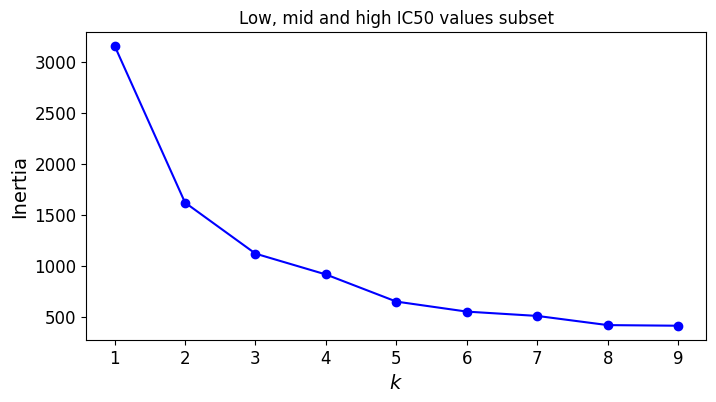

In [19]:
#checking for ideal value of k using elbow method
range_of_ks = range(1,10)
kmeans_per_k = [KMeans(n_clusters = k, n_init = 'auto').fit(X_lowmidhighIC50subset_pca) for k in range_of_ks]

inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize = (8,4))
plt.plot(range_of_ks, inertias, 'bo-')
plt.title('Low, mid and high IC50 values subset')
plt.xlabel('$k$',fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.show()

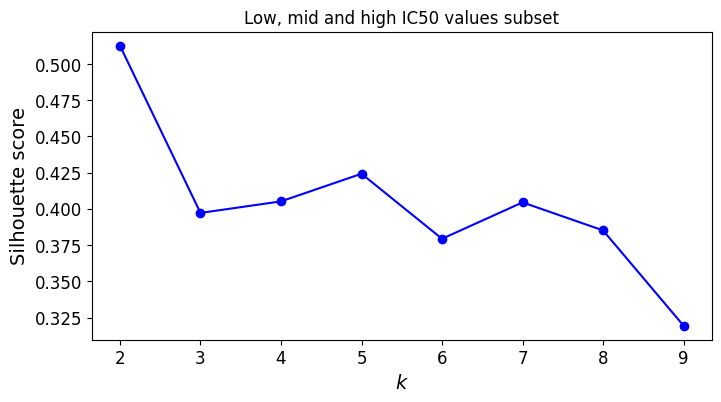

In [20]:
#checking for ideal value of k using silhoutte score method
silhouette_scores = [silhouette_score(X_lowmidhighIC50subset_pca, model.labels_)
                     for model in kmeans_per_k[1:]]
plt.figure(figsize=(8,4))
plt.plot(range_of_ks[1:],silhouette_scores,'bo-')
plt.title('Low, mid and high IC50 values subset')
plt.xlabel('$k$',fontsize=14)
plt.ylabel('Silhouette score',fontsize=14)
plt.show()

In [21]:
num_clusters = 5 #based on elbow and silhoutte scores
kmeans = KMeans(n_clusters=num_clusters, init ='k-means++', random_state=42) #initialising the model
kmeans.fit(X_lowmidhighIC50subset_scaled) #fitting the model to my scaled data

y_pred = kmeans.predict(X_lowmidhighIC50subset_scaled) #obtaining y predictions based on scaled concatenated dataset
print('len(y_pred) =', len(y_pred))

cluster_labels = kmeans.labels_ #getting the cluster labels for each data point
clustered_data = np.column_stack((X_lowmidhighIC50subset_scaled, cluster_labels))
print('len(clustered_data) =', len(clustered_data))#displaying the clustered data

#determining the number of ligands within each cluster
frame = pd.DataFrame(X_lowmidhighIC50subset_scaled)
frame['cluster'] = y_pred
frame['cluster'].value_counts()

len(y_pred) = 471
len(clustered_data) = 471


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0    164
1    121
3     95
4     83
2      8
Name: cluster, dtype: int64

In [22]:
#creating dataframe which shows which ligands are within each cluster specifically
featurised = pd.concat([lowmidhighsubset_lig_SMILES_df, IC50lowmidhigh_RDkitsubset],axis=1)
featurised = featurised.set_index('Ligand SMILES')
#using code from https://github.com/OpenClassrooms-Student-Center/
X_lowmidhighIC50subset_pca_df = pd.DataFrame(X_lowmidhighIC50subset_pca, index=featurised.index, columns=['PC1','PC2']) #convert to df
X_lowmidhighIC50subset_pca_df['cluster'] = kmeans.predict(X_lowmidhighIC50subset_scaled)
X_lowmidhighIC50subset_pca_df

,PC1,PC2,cluster
Ligand SMILES,,,
Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,-1.726428,-1.532152,0
CC(C)(C)CNc1nc(ncc1C(=O)NCCc1ccc(OCCn2ccnc2)cc1)C#N,0.329280,0.577147,3
CC(C)(C)CNc1nc(ncc1C(=O)NCCc1cccc(OCCn2ccnc2)c1)C#N,0.329280,0.577147,3
OCC1C(O)C(O)C(O)c2nc(CCCc3ccc(cc3)-c3ccccc3)cn12,-0.088242,1.208551,3
CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,-1.551742,-0.668717,0
...,...,...,...
Clc1ccc(cc1C(=O)Nc1sc2CCCc2c1C#N)S(=O)(=O)C1CCOCC1,-1.103006,0.417272,0
FC(F)(F)c1ccc(cc1)N1CCN(CC1)C(=O)[C@@H](c1ccc(Cl)cc1)c1cccnc1,-1.523750,-1.486015,0
Nc1c(sc2nc(ccc12)-c1cccs1)C(=O)Nc1cc(Cl)ccc1Cl,-0.493438,-1.462333,1


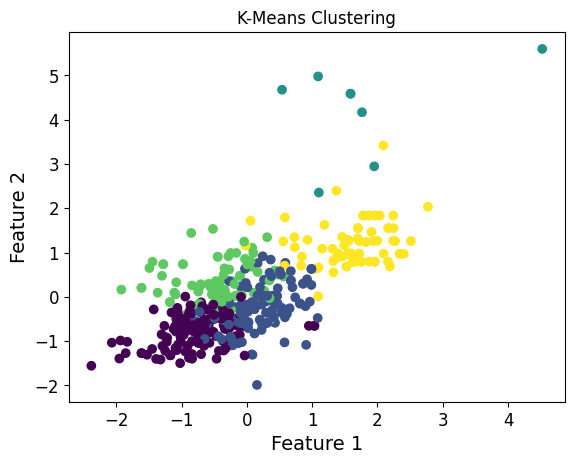

In [23]:
#a simple visualisation of the clusters
plt.scatter(X_lowmidhighIC50subset_scaled[:,0], X_lowmidhighIC50subset_scaled[:,1], c=cluster_labels, cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [24]:
#some definitions for further cluster visualisation using code from https://github.com/OpenClassrooms-Student-Center/
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    '''Display a scatter plot on a factorial plane, one for each factorial plane'''

    # For each factorial plane
    for d1,d2 in axis_ranks:
        if d2 < n_comp:

            # Initialise the matplotlib figure
            fig = plt.figure(figsize=(7,6))

            # Display the points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # Display the labels on the points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center')

            # Define the limits of the chart
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])

            # Display grid lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection of points (on PC{} and PC{})".format(d1+1, d2+1))
            #plt.show(block=False)

palette = sns.color_palette("bright", 10)
def addAlpha(colour, alpha):
    '''Add an alpha to the RGB colour'''

    return (colour[0],colour[1],colour[2],alpha)
def display_parallel_coordinates(df, num_clusters):
    '''Display a parallel coordinates plot for the clusters in df'''

    # Select data points for individual clusters
    cluster_points = []
    for i in range(num_clusters):
        cluster_points.append(df[df.cluster==i])

    # Create the plot
    fig = plt.figure(figsize=(12, 15))
    title = fig.suptitle("Parallel Coordinates Plot for the Clusters", fontsize=18)
    fig.subplots_adjust(top=0.95, wspace=0)

    # Display one plot for each cluster, with the lines for the main cluster appearing over the lines for the other clusters
    for i in range(num_clusters):
        plt.subplot(num_clusters, 1, i+1)
        for j,c in enumerate(cluster_points):
            if i!= j:
                pc = parallel_coordinates(c, 'cluster', color=[addAlpha(palette[j],0.2)])
        pc = parallel_coordinates(cluster_points[i], 'cluster', color=[addAlpha(palette[i],0.5)])

        # Stagger the axes
        ax=plt.gca()
        for tick in ax.xaxis.get_major_ticks()[1::2]:
            tick.set_pad(20)


def display_parallel_coordinates_centroids(df, num_clusters):
    '''Display a parallel coordinates plot for the centroids in df'''

    # Create the plot
    fig = plt.figure(figsize=(12, 5))
    title = fig.suptitle("Parallel Coordinates plot for the Centroids", fontsize=18)
    fig.subplots_adjust(top=0.9, wspace=0)

    # Draw the chart
    parallel_coordinates(df, 'cluster', color=palette)

    # Stagger the axes
    ax=plt.gca()
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20)

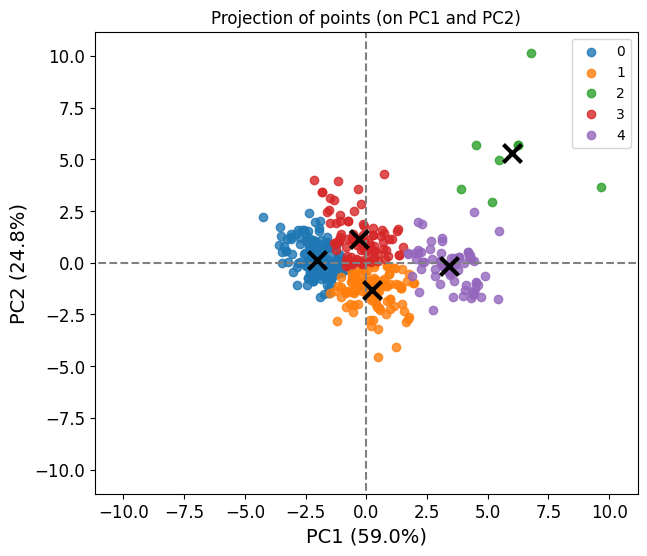

In [25]:
#isualisation of clusters after performing pca
pca = PCA(n_components = 2)
pca.fit(X_lowmidhighIC50subset_scaled)
X_lowmidhighIC50subset_pca = pca.transform(X_lowmidhighIC50subset_scaled)
centres_reduced = pca.transform(kmeans.cluster_centers_)
display_factorial_planes(X_lowmidhighIC50subset_pca, 2, pca, [(0,1)], illustrative_var = y_pred, alpha = 0.8)
plt.scatter(centres_reduced[:, 0], centres_reduced[:, 1],
            marker='x', s=169, linewidths=3,
            color='k', zorder=10)

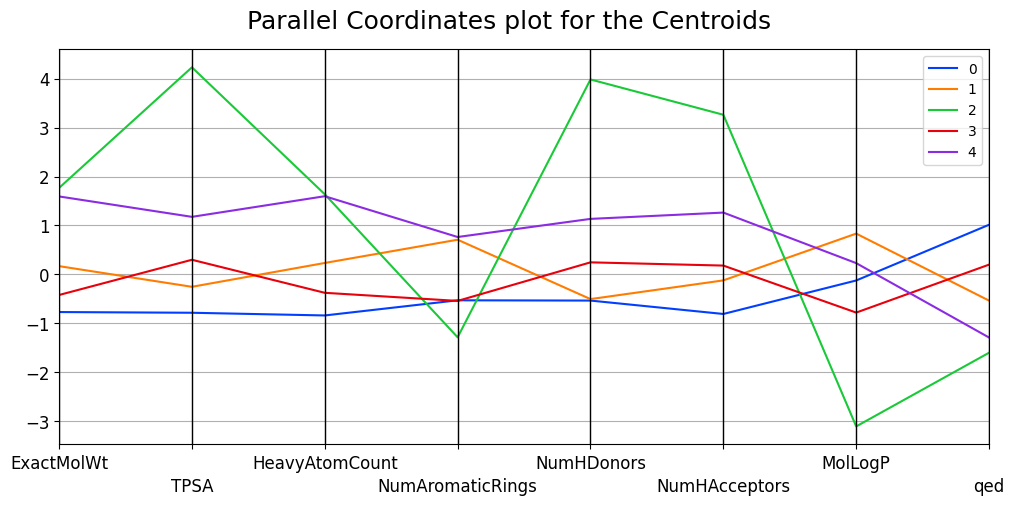

In [26]:
#for visualisation of distribution of important features within each cluster
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=featurised.columns)
centroids['cluster'] = centroids.index

display_parallel_coordinates_centroids(centroids, 5)

In [35]:
#random forest for low IC50 subset
rndfor = RandomForestClassifier(n_estimators = 500)
rndfor.fit(IC50low_RDkitsubset, lowIC50subset['IC50 (nM)'])

for name, imp in zip(IC50low_RDkitsubset.columns,rndfor.feature_importances_):
    print(name.ljust(20), round(imp,2))

ExactMolWt           0.18
TPSA                 0.14
HeavyAtomCount       0.14
NumAromaticRings     0.05
NumHDonors           0.06
NumHAcceptors        0.09
MolLogP              0.16
qed                  0.17


In [36]:
#random forest for high IC50 subset
rndfor = RandomForestClassifier(n_estimators = 500)
rndfor.fit(IC50high_RDkitsubset, highIC50subset['IC50 (nM)'])

for name, imp in zip(IC50high_RDkitsubset.columns,rndfor.feature_importances_):
    print(name.ljust(20), round(imp,2))

ExactMolWt           0.16
TPSA                 0.19
HeavyAtomCount       0.1
NumAromaticRings     0.08
NumHDonors           0.08
NumHAcceptors        0.1
MolLogP              0.15
qed                  0.14
